In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense
from keras.preprocessing import image as kerasImage
from PIL import Image as pilImage
from scipy.ndimage.filters import gaussian_filter, median_filter
%matplotlib inline
import matplotlib.pyplot as plt
import keras.backend as K
import imageio
import subprocess
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def deprocess_image(x):    
    x -= x.mean(); x /= (x.std() + K.epsilon()); x*= 0.25
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
### -- ACTIVATION MAXIMIZATION FOR ONE FILTER OF A SPECIFIC LAYER -- #
if not os.path.isdir('./Results/Nguyen'):
    os.mkdir('./Results/Nguyen')

# -- DEFINE MODEL -- #    
model = VGG16(weights='imagenet',include_top=True)
weights = model.layers[-1].get_weights()
model.layers.pop()
model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1].output]
output = Dense(1000,activation='linear')(model.outputs[0])
model = Model(inputs=model.inputs,outputs=[output])
model.layers[-1].set_weights(weights)
for layer in model.layers:
    layer.trainable = False
imgInput = model.inputs[0]
prediction = model.outputs[0]

# -- DEFINE HYPERPARAMETERS -- #
size = model.input_shape[1:][0]
learningRate = 12000
l2Decay = 0.0
medianFilterSize = 5
medianFilterEvery = 4
earlyStop = 0
blurStd = 0.12
blurEvery = 20

# -- NESTEROV HYPERPARAMETERS -- #
momentum = 0.9
velocity = np.zeros(model.input_shape[1:])

# -- RMSPROP HYPERPARAMETERS -- #
decayRate = 0.9
cache = np.zeros(model.input_shape[1:])

# -- ADAM HYPERPARAMETERS -- #
beta1 = 0.9
beta2 = 0.999
m = np.zeros(model.input_shape[1:])
v = np.zeros(model.input_shape[1:])

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# -- SELECT CLASS TO MAXIMIZE -- #
imgSel = input('Select an image: ')
fileName = './Data/images/'+imgSel+'.jpg'
pred = model.predict(imgInputData)
top = decode_predictions(pred, top=5)[0]
classes = np.argsort(pred[0])[-5:][::-1]
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
epochs = int(input('Select the number of iterations:'))
selClass = int(input('Select the class you want to maximize (0-{0})'.format(prediction.get_shape()[1]-1)))
option = int(input('Select the Method of gradient: Classic(0), Nesterov(1), RMSProp(2), Adam(3)'))
gifImg = []

# -- DEFINE LOSS & GRADIENT -- #
loss = prediction[0,selClass]
grads = K.gradients(loss,imgInput)[0]
iterate = K.function([imgInput],[loss,grads])

Select an image:  test_76


Model prediction:
	lacewing       	(318)	with probability 10.531
	dragonfly      	(319)	with probability 10.428
	cicada         	(316)	with probability 9.201
	fly            	(308)	with probability 9.012
	mosquito_net   	(669)	with probability 7.856


Select the number of iterations: 400
Select the class you want to maximize (0-999) 316
Select the Method of gradient: Classic(0), Nesterov(1), RMSProp(2), Adam(3) 1


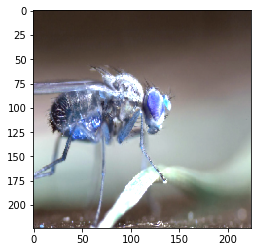

In [29]:
# -- APPLY REGULARIZATION TO INPUT IMAGE -- #
imgInputData = load_image(fileName)
imgInputData = gaussian_filter(imgInputData, sigma=[0, 0.5, 0.5, 0])
plt.imshow(deprocess_image(imgInputData[0]))
plt.show()

In [30]:
# -- START ITERATION -- #
gifImg.append(imgInputData[0].copy())
for k in range(epochs):
    if option == 0:
        lossVal,gradVal = iterate([imgInputData])
        imgInputData += gradVal*learningRate
    elif option == 1:
        lossVal,gradVal = iterate([imgInputData+momentum*velocity])
        velocity = momentum*velocity+learningRate*gradVal
        imgInputData += velocity
    elif option == 2:
        lossVal, gradVal = iterate([imgInputData])
        cache = decayRate*cache+(1-decayRate)*np.square(gradVal)
        imgInputData += learningRate * gradVal / (np.sqrt(cache) + K.epsilon())
    elif option == 3:
        lossVal, gradVal = iterate([imgInputData])
        m = beta1 * m + (1-beta1) * gradVal
        v = beta2 * v + (1-beta2) * np.square(gradVal)
        imgInputData += learningRate * m / (np.sqrt(v) + K.epsilon())
    else:
        break
    # -- EARLY STOPPING -- #
    if earlyStop is not 0 and lossVal >= earlyStop:
        break
    # -- CLIPPING -- #
    imgInputData = np.clip(imgInputData,0,255).astype('float32')
    # -- REGULARIZATION -- #
    if k != epochs-1:
        if l2Decay > 0:
            imgInputData *= (1-l2Decay)
        if blurStd is not 0 and k % blurEvery == 0:
            imgInputData = gaussian_filter(imgInputData, sigma=[0, blurStd, blurStd, 0])
        if medianFilterSize is not 0 and k % medianFilterEvery == 0 :
            imgInputData = median_filter(imgInputData, size=(1, medianFilterSize, medianFilterSize, 1))
    gifImg.append(imgInputData[0].copy())

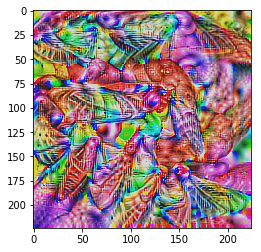

In [31]:
# -- SAVE RESULTS -- #
img = deprocess_image(imgInputData[0])
plt.imshow(img)
plt.show()
img = kerasImage.array_to_img(img,scale=False)
img.save('./Results/Nguyen/Class_'+str(selClass)+'.png')